In [45]:
import statistics as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preparação dos dados

## Recolha de dados

In [46]:
file_path = "Car_Insurance_Claim.csv"
dataset = pd.read_csv(file_path)

In [47]:
dataset_final = dataset.copy()

## Eliminar colunas irrelevantes para o modelo

In [48]:
removed_cols = [col for col in ["ID", "POSTAL_CODE"] if col in dataset_final.columns]
dataset_final.drop(columns=removed_cols, inplace=True)

## Eliminar valores omissos

In [49]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(dataset[['CREDIT_SCORE', 'ANNUAL_MILEAGE']])
dataset_final[['CREDIT_SCORE', 'ANNUAL_MILEAGE']] = imputer.transform(dataset[['CREDIT_SCORE', 'ANNUAL_MILEAGE']])

num_obs_antes = dataset_final.shape[0]
cols_numeric = ['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']

for col in cols_numeric:
    p99 = dataset_final[col].quantile(0.99)
    dataset_final = dataset_final[dataset_final[col] <= p99]

num_obs_depois = dataset_final.shape[0]
observacoes_removidas = num_obs_antes - num_obs_depois
print(f"Número de observações eliminadas: {observacoes_removidas}")


Número de observações eliminadas: 399


In [50]:
dataset_final.isnull().sum()

AGE                    0
GENDER                 0
DRIVING_EXPERIENCE     0
EDUCATION              0
INCOME                 0
CREDIT_SCORE           0
VEHICLE_OWNERSHIP      0
VEHICLE_YEAR           0
MARRIED                0
CHILDREN               0
ANNUAL_MILEAGE         0
VEHICLE_TYPE           0
SPEEDING_VIOLATIONS    0
DUIS                   0
PAST_ACCIDENTS         0
OUTCOME                0
dtype: int64

## Tratamento de outliers

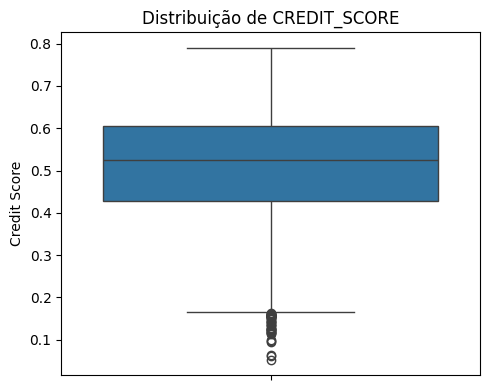

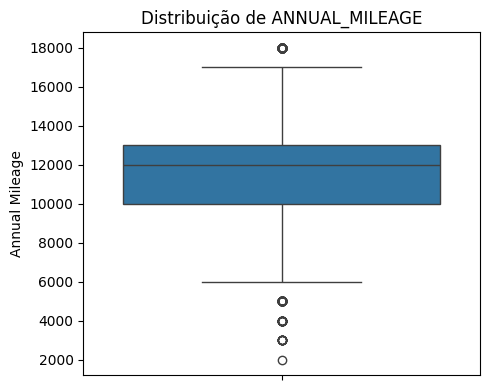

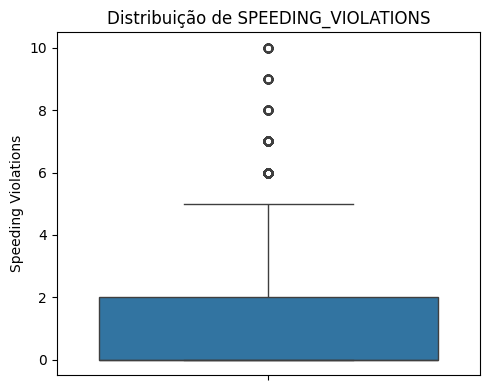

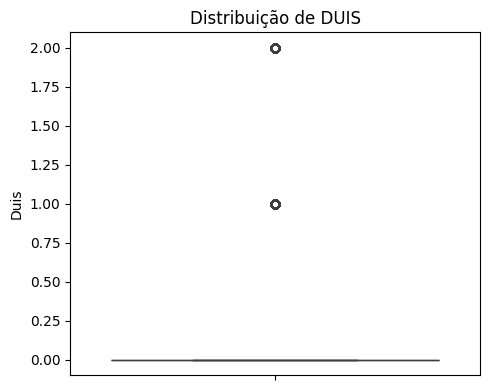

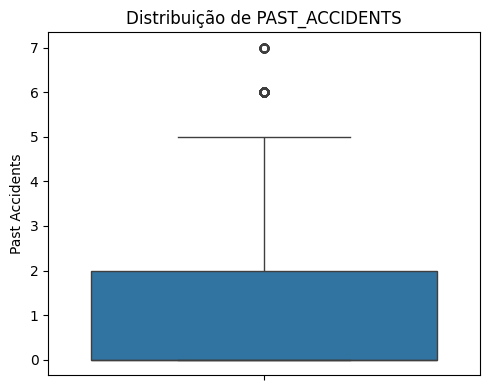

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_numeric = ['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']

for col in cols_numeric:
    plt.figure(figsize=(5, 4))
    sns.boxplot(y=dataset_final[col])
    plt.title(f'Distribuição de {col}')
    plt.ylabel(col.replace("_", " ").title())
    plt.tight_layout()
    plt.show()


## Nota
Nao faz sentido remover outliers pois não existe nenhum critico e o método de remoção pelo IQR neste caso irá remover dados uteis

In [ ]:
#def remove_outlier_IQR(df_subset):
#    Q1 = df_subset.quantile(0.25)
#    Q3 = df_subset.quantile(0.75)
#    IQR = Q3 - Q1
#    # Apenas mantém as linhas que estão dentro dos limites
#    df_filtered = df_subset[~((df_subset < (Q1 - 1.5 * IQR)) | (df_subset > (Q3 + 1.5 * IQR))).any(axis=1)]
#    return df_filtered

In [ ]:
# Passo 1: Obter as linhas sem outliers com base nas colunas numéricas
#df_outlier_removed = remove_outlier_IQR(dataset_final[cols_numeric])

# Passo 2: Identificar os índices das linhas com outliers (i.e., os que foram removidos)
#ind_diff = dataset_final.index.difference(df_outlier_removed.index)

# Passo 3: Remover cada linha com outlier (uma a uma)
#for i in range(0, len(ind_diff), 1):
#    dataset_final = dataset_final.drop([ind_diff[i]])


# Passo 4: Mostrar quantas linhas com outliers foram removidas
#print(f"Foram removidas {len(ind_diff)} linhas com outliers nas variáveis: {', '.join(cols_numeric)}.")
#print(f"O dataset final contém {dataset_final.shape[0]} observações.")

#Verificar o número de outliers removidos.
#print("Foram removidos ",len(ind_diff),"outliers.")

Foram removidas 2222 linhas com outliers nas variáveis: CREDIT_SCORE, ANNUAL_MILEAGE, SPEEDING_VIOLATIONS, DUIS, PAST_ACCIDENTS.
O dataset final contém 7379 observações.
Foram removidos  2222 outliers.


## Codificar variáveis categóricas

In [52]:
ordinal_features = ['AGE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME', 'VEHICLE_YEAR']
ordinal_categories = [
    ['16-25', '26-39', '40-64', '65+'],
    ['0-9y', '10-19y', '20-29y', '30y+'],
    ['none', 'high school', 'university'],
    ['poverty', 'working class', 'middle class', 'upper class'],
    ['before 2015', 'after 2015']
]

nominal_features = ['GENDER', 'VEHICLE_TYPE']


preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
        ('nom', OneHotEncoder(drop='first', sparse_output=False), nominal_features)
    ],
    remainder='passthrough'
)

encoded_array = preprocessor.fit_transform(dataset_final)

ord_cols = ordinal_features
nom_cols = preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_features)
rest_cols = [col for col in dataset_final.columns if col not in ordinal_features + nominal_features]
final_columns = list(ord_cols) + list(nom_cols) + rest_cols

dataset_encoded = pd.DataFrame(encoded_array, columns=final_columns)

X = dataset_encoded.drop(columns=['OUTCOME'])
y = dataset_encoded['OUTCOME']

le = LabelEncoder()
y = le.fit_transform(y)

dataset_final = pd.DataFrame(dataset_encoded, columns=final_columns)

In [53]:
dataset_final.head()

,AGE,DRIVING_EXPERIENCE,EDUCATION,INCOME,VEHICLE_YEAR,GENDER_male,VEHICLE_TYPE_sports car,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,3.0,0.0,1.0,3.0,1.0,0.0,0.0,0.629027,1.0,0.0,1.0,12000.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.357757,0.0,0.0,0.0,16000.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.493146,1.0,0.0,0.0,11000.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.206013,1.0,0.0,1.0,11000.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.388366,1.0,0.0,0.0,12000.0,2.0,0.0,1.0,1.0


In [54]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601 entries, 0 to 9600
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGE                      9601 non-null   float64
 1   DRIVING_EXPERIENCE       9601 non-null   float64
 2   EDUCATION                9601 non-null   float64
 3   INCOME                   9601 non-null   float64
 4   VEHICLE_YEAR             9601 non-null   float64
 5   GENDER_male              9601 non-null   float64
 6   VEHICLE_TYPE_sports car  9601 non-null   float64
 7   CREDIT_SCORE             9601 non-null   float64
 8   VEHICLE_OWNERSHIP        9601 non-null   float64
 9   MARRIED                  9601 non-null   float64
 10  CHILDREN                 9601 non-null   float64
 11  ANNUAL_MILEAGE           9601 non-null   float64
 12  SPEEDING_VIOLATIONS      9601 non-null   float64
 13  DUIS                     9601 non-null   float64
 14  PAST_ACCIDENTS          

## Guardar dataset final

In [55]:
dataset_final.to_csv("Car_Insurance_Claim_Prepared.csv", index=False)

## Dividir o dataset em conjunto de treino e teste

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Feature scalling

In [57]:
for i, col in enumerate(final_columns):
    print(f"{i}: {col}")

0: AGE
1: DRIVING_EXPERIENCE
2: EDUCATION
3: INCOME
4: VEHICLE_YEAR
5: GENDER_male
6: VEHICLE_TYPE_sports car
7: CREDIT_SCORE
8: VEHICLE_OWNERSHIP
9: MARRIED
10: CHILDREN
11: ANNUAL_MILEAGE
12: SPEEDING_VIOLATIONS
13: DUIS
14: PAST_ACCIDENTS
15: OUTCOME


In [58]:
scaler = StandardScaler()
numeric_cols = ['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Modelação dos Dados

### Ajuste de Hiperparâmetros com GridSearchCV

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

modelos_parametros = {
    "Logistic Regression": {
        "modelo": LogisticRegression(max_iter=1000),
        "parametros": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "KNN": {
        "modelo": KNeighborsClassifier(),
        "parametros": {
            "n_neighbors": list(range(1, 21)),
            "metric": ["euclidean", "manhattan", "minkowski"],
            "weights": ["uniform", "distance"]
        }
    },
    "Decision Tree": {
        "modelo": DecisionTreeClassifier(random_state=0),
        "parametros": {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "modelo": RandomForestClassifier(random_state=0),
        "parametros": {
            "n_estimators": [10, 50, 100],
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 5, 10],
        }
    },
    "Naive Bayes": {
        "modelo": GaussianNB(),
        "parametros": {}
    },
    "SVM": {
        "modelo": SVC(),
        "parametros": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"]
        }
    }
}

melhores_modelos = {}

for nome, dic in modelos_parametros.items():
    print(f"\nModelo a ajustar: {nome}")
    grid = GridSearchCV(dic["modelo"], dic["parametros"], cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Melhor combinação:", grid.best_params_)
    print("Melhor accuracy média:", grid.best_score_)
    melhores_modelos[nome] = grid.best_estimator_



Modelo a ajustar: Logistic Regression
Melhor combinação: {'C': 10, 'solver': 'liblinear'}
Melhor accuracy média: 0.8345052083333334

Modelo a ajustar: KNN
Melhor combinação: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'uniform'}
Melhor accuracy média: 0.8131510416666667

Modelo a ajustar: Decision Tree
Melhor combinação: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Melhor accuracy média: 0.8243489583333334

Modelo a ajustar: Random Forest
Melhor combinação: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
Melhor accuracy média: 0.8265625

Modelo a ajustar: Naive Bayes
Melhor combinação: {}
Melhor accuracy média: 0.7700520833333333

Modelo a ajustar: SVM
Melhor combinação: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Melhor accuracy média: 0.8328125


In [60]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

resultados = []
modelos_otimizados = {}

for nome, info in modelos_parametros.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', info['modelo'])
    ])
    param_grid = {f"clf__{param}": valores 
                  for param, valores in info['parametros'].items()}

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )
    grid.fit(X_train, y_train)

    modelos_otimizados[nome] = grid.best_estimator_
    df = pd.DataFrame(grid.cv_results_).assign(Modelo=nome)
    resultados.append(df)

resultados_grid = pd.concat(resultados, ignore_index=True)
resultados_grid.to_csv("resultados_gridsearch_todos.csv", index=False)
print("Resultados do Grid Search salvos em 'resultados_gridsearch_todos.csv'")


Fitting 100 folds for each of 8 candidates, totalling 800 fits
Fitting 100 folds for each of 120 candidates, totalling 12000 fits
Fitting 100 folds for each of 24 candidates, totalling 2400 fits
Fitting 100 folds for each of 18 candidates, totalling 1800 fits
Fitting 100 folds for each of 1 candidates, totalling 100 fits
Fitting 100 folds for each of 18 candidates, totalling 1800 fits
Resultados do Grid Search salvos em 'resultados_gridsearch_todos.csv'


In [61]:
import pandas as pd
import pprint

df = pd.read_csv("resultados_gridsearch_todos.csv")

best_params = {}
for nome, grupo in df.groupby('Modelo'):
    best = grupo[grupo['rank_test_score'] == 1].iloc[0]
    params = {col.replace('param_clf__',''): best[col]
              for col in df.columns if col.startswith('param_clf__')}
    best_params[nome] = params

pprint.pprint(best_params)

{'Decision Tree': {'C': np.float64(nan),
                   'criterion': 'gini',
                   'gamma': nan,
                   'kernel': nan,
                   'max_depth': np.float64(5.0),
                   'metric': nan,
                   'min_samples_split': np.float64(2.0),
                   'n_estimators': np.float64(nan),
                   'n_neighbors': np.float64(nan),
                   'solver': nan,
                   'weights': nan},
 'KNN': {'C': np.float64(nan),
         'criterion': nan,
         'gamma': nan,
         'kernel': nan,
         'max_depth': np.float64(nan),
         'metric': 'manhattan',
         'min_samples_split': np.float64(nan),
         'n_estimators': np.float64(nan),
         'n_neighbors': np.float64(19.0),
         'solver': nan,
         'weights': 'uniform'},
 'Logistic Regression': {'C': np.float64(0.1),
                         'criterion': nan,
                         'gamma': nan,
                         'kernel': nan,
       

## Comparação das Métricas dos Modelos

Apresentamos aqui os resultados comparativos entre os modelos treinados.

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

metricas_modelos = []
for nome, modelo in modelos_otimizados.items():
    y_pred = modelo.predict(X_test)
    metricas_modelos.append({
        "Modelo": nome,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

df_metricas = pd.DataFrame(metricas_modelos).sort_values(by="Accuracy", ascending=False)
display(df_metricas)

,Modelo,Accuracy,Precision,Recall,F1-Score
2,Decision Tree,0.855804,0.775801,0.742760,0.758921
0,Logistic Regression,0.851640,0.765845,0.741056,0.753247
5,SVM,0.850078,0.743883,0.776831,0.760000
3,Random Forest,0.849037,0.763766,0.732538,0.747826
1,KNN,0.837585,0.737478,0.727428,0.732419
4,Naive Bayes,0.781364,0.609724,0.790460,0.688427


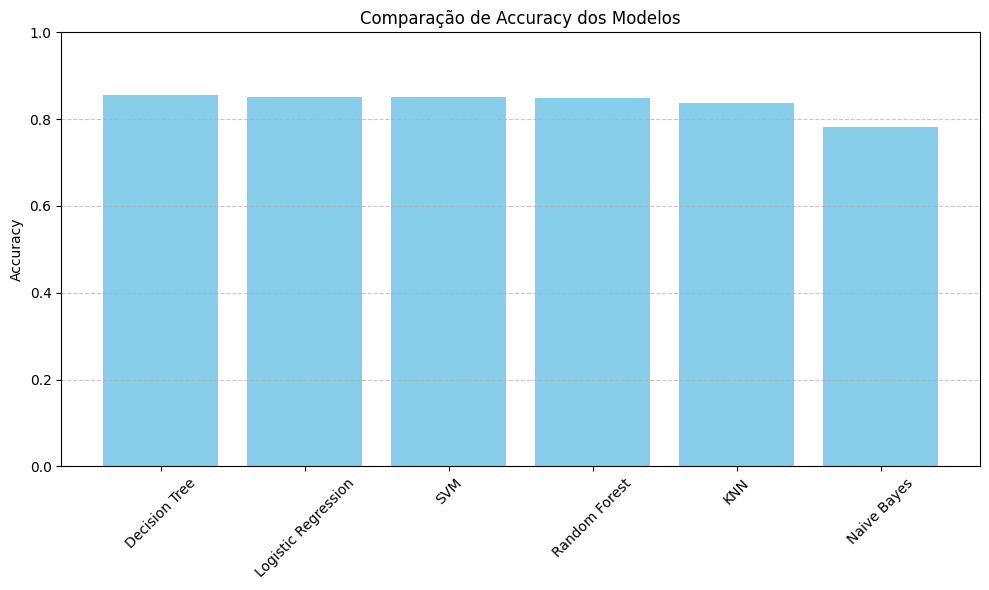

In [63]:
plt.figure(figsize=(10, 6))
plt.bar(df_metricas["Modelo"], df_metricas["Accuracy"], color='skyblue')
plt.title("Comparação de Accuracy dos Modelos")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Melhor modelo segundo f1_macro (CV): SVM
Melhor número de features: 15


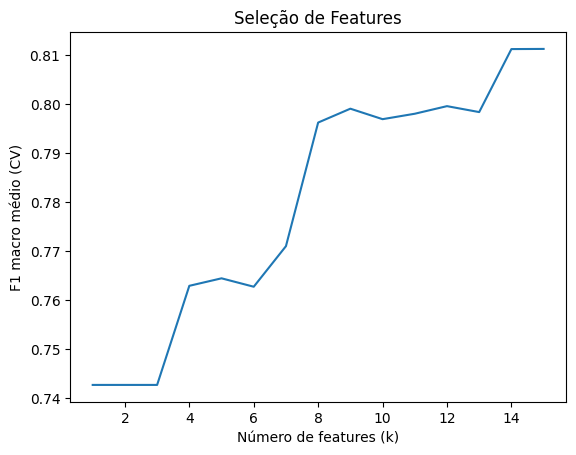

In [64]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

melhores = (resultados_grid
            .groupby('Modelo')['mean_test_score']
            .max()
            .sort_values(ascending=False))
best_model_name = melhores.index[0]
best_pipeline = modelos_otimizados[best_model_name]
print(f"Melhor modelo segundo f1_macro (CV): {best_model_name}")

n_features = X_train.shape[1]
k_range = list(range(1, n_features + 1))
mean_f1 = []

for k in k_range:
    pipe_fs = Pipeline([
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=k)),
        ('clf', best_pipeline.named_steps['clf'])
    ])
    scores = cross_val_score(pipe_fs, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    mean_f1.append(scores.mean())

best_k = k_range[int(np.argmax(mean_f1))]
print(f"Melhor número de features: {best_k}")

plt.figure()
plt.plot(k_range, mean_f1)
plt.xlabel("Número de features (k)")
plt.ylabel("F1 macro médio (CV)")
plt.title("Seleção de Features")
plt.show()

In [65]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=best_k)),
    ('clf', best_pipeline.named_steps['clf'])
])

final_pipeline.fit(X_train, y_train)

y_pred_final = final_pipeline.predict(X_test)
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_final))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_final))

Matriz de Confusão:
[[1177  157]
 [ 131  456]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1334
           1       0.74      0.78      0.76       587

    accuracy                           0.85      1921
   macro avg       0.82      0.83      0.83      1921
weighted avg       0.85      0.85      0.85      1921



In [66]:
import joblib

joblib.dump(final_pipeline, "modelo_final.pkl")
print("Modelo final salvo em 'modelo_final.pkl'")

Modelo final salvo em 'modelo_final.pkl'
